In [1]:
import sys, os
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'] + '/azav')

import numpy as np
import scipy as sp
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

from azav_util import *
from plotcommon import *
from common import *

In [2]:
# Get Rachel's solar data
di = get_dict('gongdata/avgong1995-2009rls.pkl')
di.keys()

dict_keys(['om', 'om_err', 'nt', 'nr', 'tt', 'rr', 'sint', 'cost', 'rr_2d', 'tt_2d', 'sint_2d', 'cost_2d', 'xx', 'zz'])

In [3]:
# cut the data off below 0.5*rsun (like in Rachel's plot)
rbot = 0.5*rsun

In [4]:
# diffrot in "lab" frame
Om_nhz = di['om']
Om_err_nhz = di['om_err']

Om = Om_nhz*1e-9*(2*np.pi) # nHz --> rad/s

nt = di['nt']
nr = di['nr']

tt = di['tt']
rr = di['rr']*rsun

cost = di['cost']
sint = di['sint']

cost_2d = di['cost_2d']
sint_2d = di['sint_2d']

rr_2d = di['rr_2d']*rsun

xx = di['xx']
zz = di['zz']

In [15]:
print(np.shape(Om))
print(np.shape(tt))
print(np.shape(rr))
print(tt[1]-tt[0])
print(rr[1]-rr[0])
print(np.min(tt), np.min(tt))

(41, 38)
(41,)
(38,)
-0.032729999999999926
-17392500.0
0.261799 0.261799


In [5]:
# get rotation rate derivatives
dOmdr = np.gradient(Om, rr, axis=1)
dOmdt = np.gradient(Om, tt, axis=0)/rr_2d
dOmdz = cost_2d*dOmdr - sint_2d*dOmdt
dOmdl = sint_2d*dOmdr + cost_2d*dOmdt

Text(0.5, 1.0, 'dOm/dz')

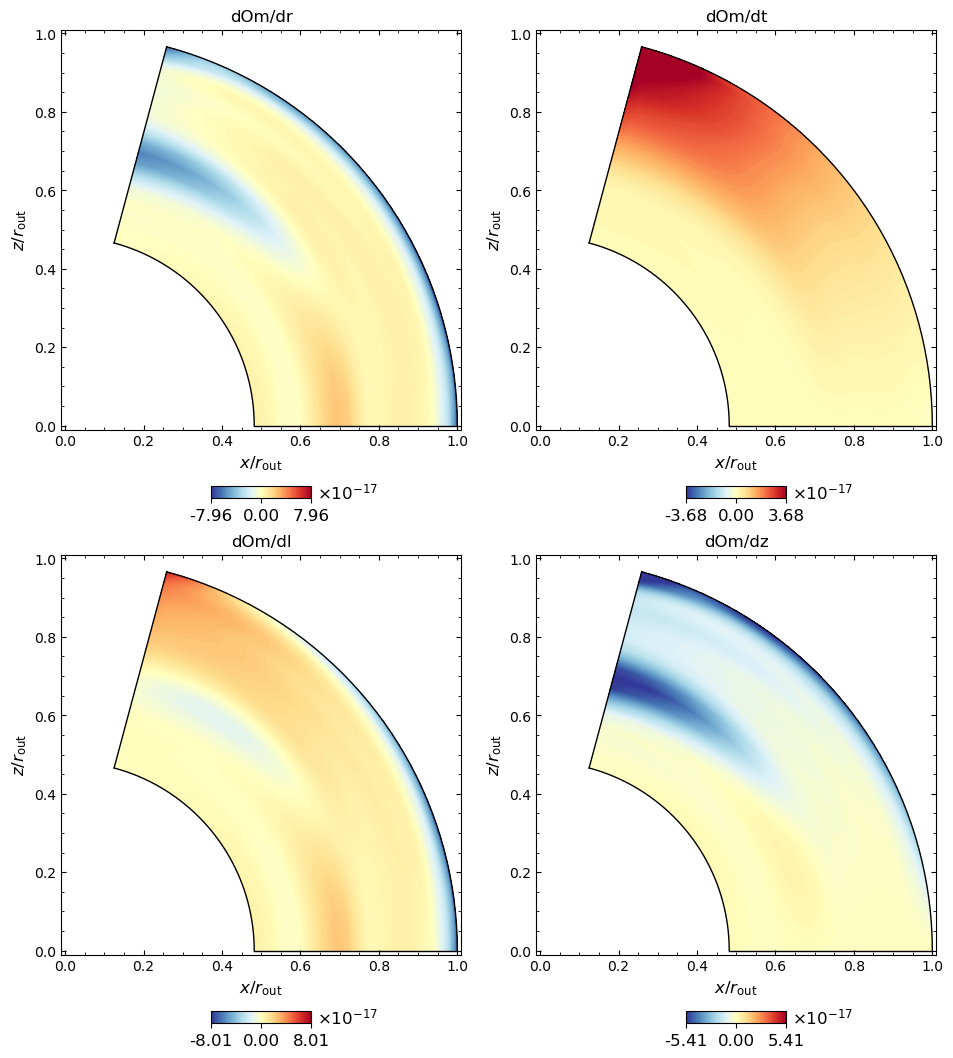

In [21]:
# plot DR derivatives

# specify any particular "command line arguments" here
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 4, 'ncontours': 20,
                     'nplots': 4, 'ncol': 2, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)

plot_azav (dOmdr, rr, cost, fig, axs[0,0], **kw_plot_azav)
plot_azav (dOmdt, rr, cost, fig, axs[0, 1], **kw_plot_azav)
plot_azav (dOmdl, rr, cost, fig, axs[1,0], **kw_plot_azav)
plot_azav (dOmdz, rr, cost, fig, axs[1, 1], **kw_plot_azav)

axs[0,0].set_title('dOm/dr')
axs[0,1].set_title('dOm/dt')
axs[1,0].set_title('dOm/dl')
axs[1,1].set_title('dOm/dz')

In [16]:
# read in model S and interpolate onto radial grid
fname = os.environ['notes'] + '/Model_S/Model_S.pkl'
model_S = get_dict(fname)
model_S.keys()

dict_keys(['msun', 'rsun', 'lsun', 'zsun', 'x0sun', 'alphasun', 'agesun', 'rr', 'lnq', 'grav', 'tmp', 'prs', 'rho', 'xfrac', 'lum', 'opa', 'eps', 'gamma', 'gamma_ad', 'delta', 'c_p', 'mue', 'ne', 'dsdr', 'nsq', 'zfrac', 'nu', 'kappa', 'eta', 'prm', 'pr', 'drhodr', 'dtmpdr', 'dprsdr', 'dlnrho', 'dlntmp', 'dlnprs', 'gas_constant', 'ircut', 'rcut', 'irbcz', 'rbcz', 'frad', 'heat', 'rtach', 'dtach', 'irtach', 'irtach1', 'irtach2', 'rtach1', 'rtach2'])

In [18]:
rr_model_S = model_S['rr']

y = model_S['grav']
f = sp.interpolate.interp1d(rr_model_S, y)
grav = f(rr)

y = model_S['c_p']
f = sp.interpolate.interp1d(rr_model_S, y)
c_p = f(rr)

y = model_S['tmp']
f = sp.interpolate.interp1d(rr_model_S, y)
tmp = f(rr)

y = model_S['rho']
f = sp.interpolate.interp1d(rr_model_S, y)
rho = f(rr)

In [8]:
# compute the thermal wind
rhs = (1./grav).reshape((1, nr)) * rr_2d**2*sint_2d * (2*Om*dOmdz)

def integrate_from_equator(arr):
    int_arr = np.zeros((nt, nr))
    for it in range(nt):
        int_arr[it, :] = np.trapz(arr[:it+1, :], tt[:it+1], axis=0)
    return int_arr

s_dev_nd = integrate_from_equator(rhs)

Text(0.5, 1.0, 'S_dev/c_p')

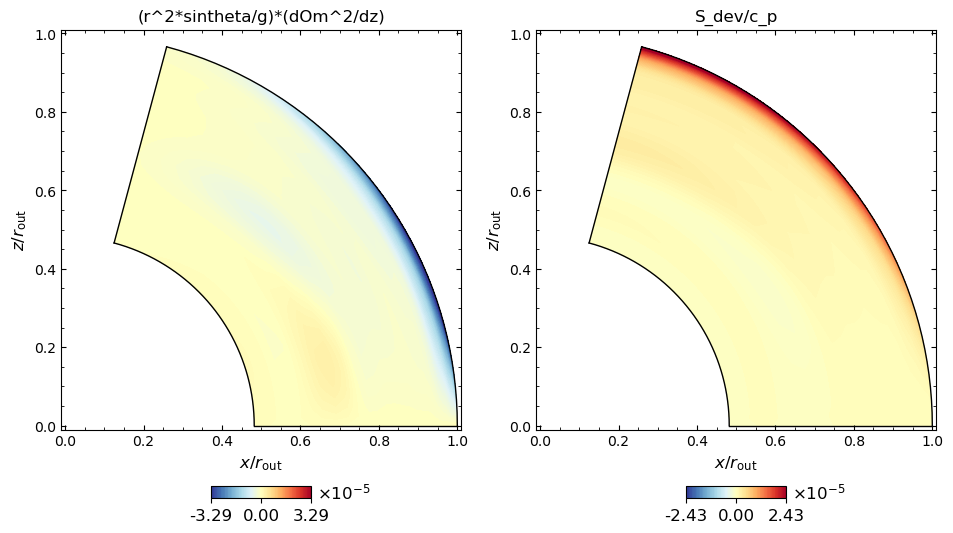

In [9]:
# plot DR derivatives, x r sin theta

# specify any particular "command line arguments" here
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 4, 'ncontours': 20,
                     'nplots': 2, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)

plot_azav (rhs, rr, cost, fig, axs[0,0], **kw_plot_azav)
#kw_plot_azav.minmax = -1e-5, 1e-5
plot_azav (s_dev_nd, rr, cost, fig, axs[0, 1], **kw_plot_azav)

axs[0,0].set_title('(r^2*sintheta/g)*(dOm^2/dz)')
axs[0,1].set_title('S_dev/c_p')

Text(0.5, 1.0, 'Solar thermal-wind temp. (K)')

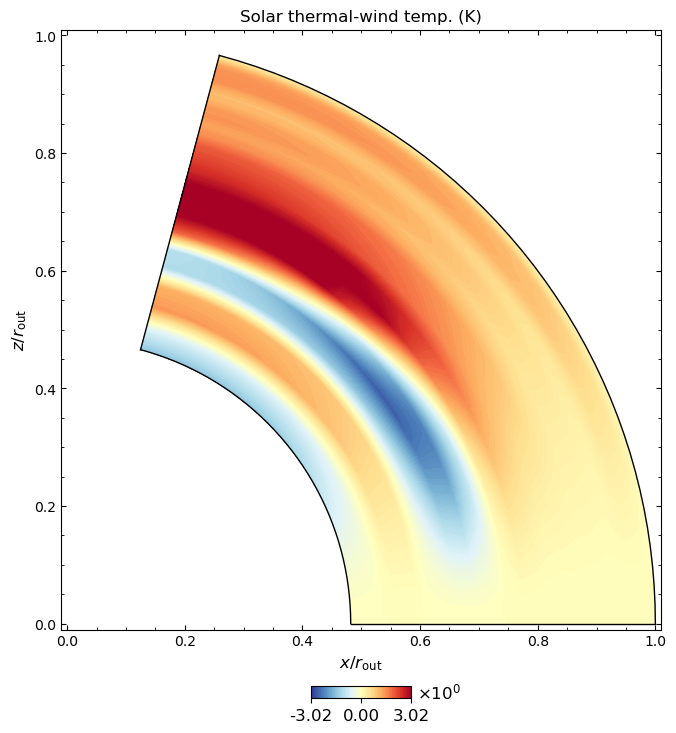

In [10]:
# compute and plot the temperature deviation (in units)
t_dev = s_dev_nd * tmp.reshape((1, nr))
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

plot_azav (t_dev, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Solar thermal-wind temp. (K)")

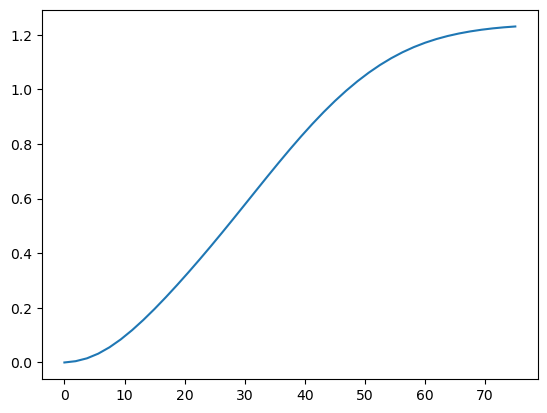

In [28]:
# plot average solar TW temp. from 0.95 to 1 rsun (over the NSSL)
r1 = 0.95*rsun
r2 = rsun

def volav_coloc(arr, r1, r2):
    ir1, ir2 = inds_from_vals(rr, [r1, r2])
    arr_loc = arr[:, ir2:ir1+1]
    dr = -np.diff(rr)
    dr_ext = np.array(list(dr) + [dr[-1]])
    dr_loc = dr_ext[ir2:ir1+1]
    rr_loc = rr[ir2:ir1+1]
    rw = rr_loc**2*dr_loc
    nrloc = len(rw)
    return np.sum(arr_loc*rw.reshape((1,nrloc)), axis=1)/np.sum(rw)

tt_lat = 180.0/np.pi*(np.pi/2 - tt)

plt.plot(tt_lat, volav_coloc(t_dev, r1, r2))

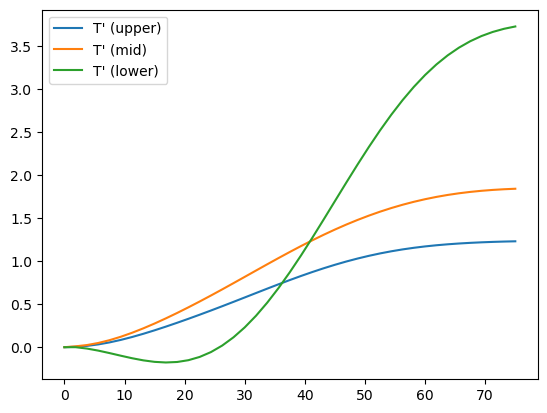

In [30]:
# really though, it's the difference in T' at different radial shells that may be important for 
# transport by meridional circulation
t_upper = volav_coloc(t_dev, 0.9*rsun, rsun)
t_mid = volav_coloc(t_dev, 0.8*rsun, 0.9*rsun)
t_lower = volav_coloc(t_dev, 0.7*rsun, 0.8*rsun)
plt.plot(tt_lat, t_upper, label = "T' (upper)")
plt.plot(tt_lat, t_mid, label = "T' (mid)")
plt.plot(tt_lat, t_lower, label = "T' (lower)")
plt.legend()

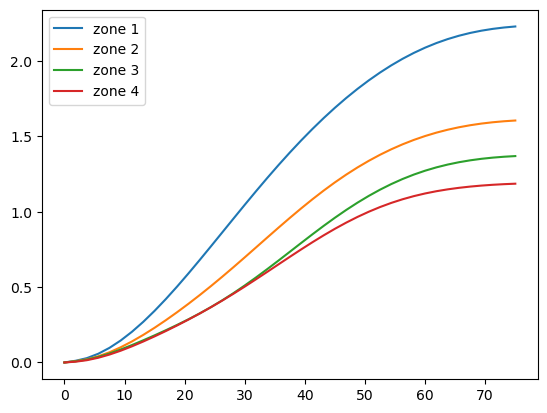

In [32]:
# but contour tilts don't change much...try four shells, between 0.8 and 0.95
r1, r2, r3, r4, r5 = np.linspace(0.8*rsun, 0.95*rsun, 5)
plt.plot(tt_lat, volav_coloc(t_dev, r1, r2), label = 'zone 1')
plt.plot(tt_lat, volav_coloc(t_dev, r2, r3), label = 'zone 2')
plt.plot(tt_lat, volav_coloc(t_dev, r3, r4), label = 'zone 3')
plt.plot(tt_lat, volav_coloc(t_dev, r4, r5), label = 'zone 4')

plt.legend()

In [33]:
# nope there's still an effect. 

In [34]:
# estimate transport of MC
utheta = 1000. # 10 m/s
cp = 3.5e8
rho = 0.01
# area at 45 degrees lat., cone spanning (0.9*rsun, rsun)
area = 2*np.pi*(rsun/np.sqrt(2)) * 0.1*rsun

# try transport assuming a value for the temperature difference between concentric shells
mass_flux = rho*utheta*area
L_theta = mass_flux * cp * 0.5
L_theta/lsun

0.0009784477660691553

In [36]:
# that's 1 in 10^3, same as Rast observations!
